In [1]:
from keras.models import Model
from keras.layers import Input, CuDNNLSTM, Dense
import numpy as np
import pandas as pd
from numpy.random import seed
seed(1)

batch_size = 64 
latent_dim = 256  
num_samples = 10000  


In [2]:
df = pd.read_csv('/content/bel.txt',delimiter='\t',header = None).iloc[:,:2]
df.columns = ['eng','bel']

In [4]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

for line in df.iterrows():
    input_text = line[1]['eng']
    target_text = line[1]['bel']
    
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
            
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

print('Number of samples:', len(input_texts))

Number of samples: 3833


In [5]:
input_characters = sorted(list(input_characters)) 
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)


print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)

Number of unique input tokens: 71
Number of unique output tokens: 130


In [6]:
input_token_index = {char: i for i, char in enumerate(input_characters)}
target_token_index = {char: i for i, char in enumerate(target_characters)}

max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Max sequence length for inputs: 125
Max sequence length for outputs: 115


In [7]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')


decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')


decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [8]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [9]:
encoder_inputs = Input(shape=(None, num_encoder_tokens), 
                       name = 'encoder_inputs')

encoder = CuDNNLSTM(latent_dim, 
                    return_state=True, 
                    name = 'encoder')

encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens), 
                       name = 'decoder_inputs')

decoder_lstm = CuDNNLSTM(latent_dim, 
                         return_sequences=True, 
                         return_state=True, 
                         name = 'decoder_lstm')

decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, 
                      activation='softmax', 
                      name = 'decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [10]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
history = model.fit([encoder_input_data, decoder_input_data], 
                    decoder_target_data,
                    batch_size=batch_size,
                    epochs=30,
                    validation_split=0.3)

Epoch 1/30
42/42 [==============================] - 11s 117ms/step - loss: 0.7216 - val_loss: 1.3087
Epoch 2/30
42/42 [==============================] - 4s 94ms/step - loss: 0.6921 - val_loss: 1.3178
Epoch 3/30
42/42 [==============================] - 4s 93ms/step - loss: 0.6851 - val_loss: 1.3033
Epoch 4/30
42/42 [==============================] - 4s 94ms/step - loss: 0.6777 - val_loss: 1.3045
Epoch 5/30
42/42 [==============================] - 4s 95ms/step - loss: 0.6716 - val_loss: 1.2755
Epoch 6/30
42/42 [==============================] - 4s 95ms/step - loss: 0.6626 - val_loss: 1.2762
Epoch 7/30
42/42 [==============================] - 4s 93ms/step - loss: 0.6566 - val_loss: 1.2683
Epoch 8/30
42/42 [==============================] - 4s 93ms/step - loss: 0.6521 - val_loss: 1.2558
Epoch 9/30
42/42 [==============================] - 4s 94ms/step - loss: 0.6448 - val_loss: 1.2541
Epoch 10/30
42/42 [==============================] - 4s 102ms/step - loss: 0.6385 - val_loss: 1.2341
Epoch 

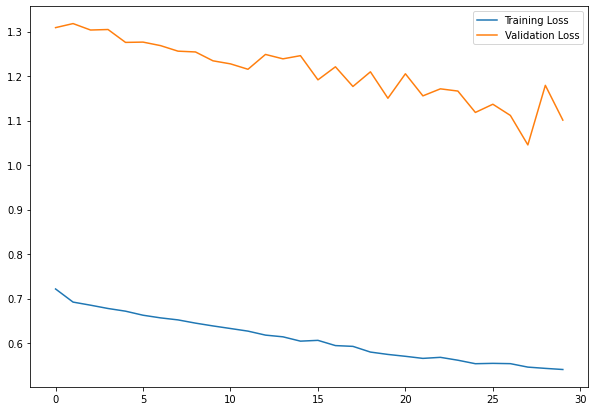

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
a, = plt.plot(history.history['loss'],label='Training Loss')
b, = plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(handles=[a,b])
plt.show()

In [12]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

reverse_input_char_index = {i: char 
                            for char, i in input_token_index.items()}
reverse_target_char_index = {i: char 
                             for char, i in target_token_index.items()}

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence

my_text = 'Hello, my name is Vlad'
placeholder = np.zeros((1,len(my_text)+10,num_encoder_tokens))

In [13]:
decode_sequence(placeholder)

'Я не падаю не та та та та та та та та та та та та та та та та та та та та та та та та та та та та та та та та та та '

TASK 2

In [14]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

In [15]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
train_len = 10000
test_len = 1000
x_train = np.reshape(x_train[:train_len], [-1, image_size, image_size, 1])
x_test = np.reshape(x_test[:test_len], [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_test = y_test[:test_len]

11501568/11490434 [==============================] - 0s 0us/step


y_train[20] =  4
y_train[500] =  3
y_train[3000] =  9
y_train[9000] =  6


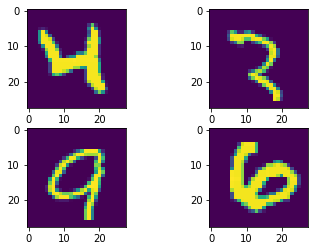

In [16]:
x_train_show = x_train.reshape(-1,28,28)
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train_show[20])
print('y_train[20] = ', y_train[20])

plt.subplot(222)
plt.imshow(x_train_show[500])
print('y_train[500] = ', y_train[500])

plt.subplot(223)
plt.imshow(x_train_show[3000])
print('y_train[3000] = ', y_train[3000])

plt.subplot(224)
plt.imshow(x_train_show[9000])
print('y_train[9000] = ', y_train[9000])
plt.show()

In [17]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [24]:
def plot_results(encoder, decoder, x_test, y_test, batch_size=128):
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)

    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 30
use_mse = True
load_weights = False

In [20]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

shape = K.int_shape(x)

x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [21]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

if use_mse:
    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
else:
    reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                              K.flatten(outputs))

reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [23]:
if load_weights:
    vae = vae.load_weights(args.weights)
else:
    # train the autoencoder
    vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None))
    vae.save_weights('vae_cnn_mnist.h5')

Epoch 1/30
313/313 [==============================] - 12s 13ms/step - loss: 55.7889 - val_loss: 49.2692
Epoch 2/30
313/313 [==============================] - 3s 11ms/step - loss: 49.5083 - val_loss: 46.4286
Epoch 3/30
313/313 [==============================] - 3s 11ms/step - loss: 46.2253 - val_loss: 45.2854
Epoch 4/30
313/313 [==============================] - 3s 11ms/step - loss: 44.1319 - val_loss: 43.5676
Epoch 5/30
313/313 [==============================] - 3s 11ms/step - loss: 42.8831 - val_loss: 42.2836
Epoch 6/30
313/313 [==============================] - 4s 14ms/step - loss: 41.9501 - val_loss: 43.2734
Epoch 7/30
313/313 [==============================] - 4s 12ms/step - loss: 41.2568 - val_loss: 42.5307
Epoch 8/30
313/313 [==============================] - 3s 11ms/step - loss: 40.6999 - val_loss: 40.6963
Epoch 9/30
313/313 [==============================] - 3s 11ms/step - loss: 40.2228 - val_loss: 40.2912
Epoch 10/30
313/313 [==============================] - 3s 11ms/step - lo

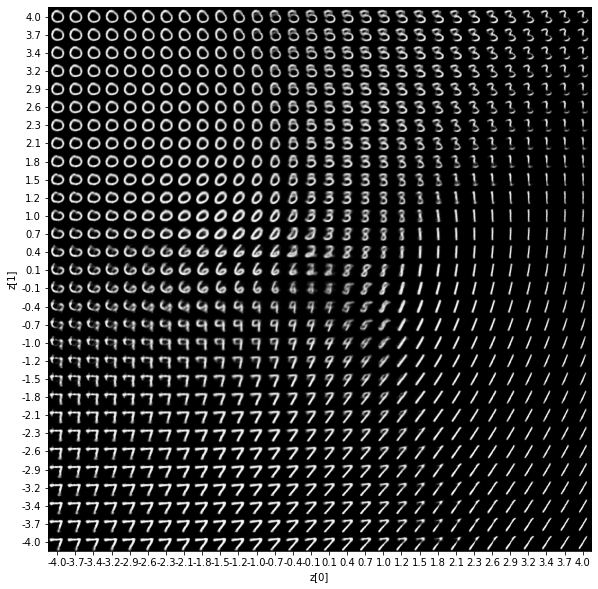

In [25]:
plot_results(encoder, decoder, x_test, y_test, batch_size=batch_size)